In [31]:
import numpy as np
import pandas as pd
import pickle
from SALib.analyze import sobol

# Parameters definition

In [32]:
kcat1        = 0.178 #Constante catalítica do consumo do éster (mmol/i.u. per min)
 
kcat2        = 0.327 #Constante catalítica da hidrólise da amoxicilina (mmol/i.u. per min)
 
Km1          = 7.905 #Constante de Michaelis-Menten ou constante de afinidade para consumo do éster(mM) 
 
Km2          = 12.509 #Constante de Michaelis-Menten ou constante de afinidade para hidrólise da amoxicilina(mM)
 
Tmax         = 0.606 #Taxa de conversão máxima do complexo acil-enzima-núcleo em produto
 
Ken          = 14.350 #Constante de adsorção do 6-APA
 
kAB          = 3.78 #Constante de inibição do éster (POHPGME)(mM)
 
kAN          = 9.174 #Constante de inibição da amoxicilina (mM)
 
kAOH         = 10.907 #Constante de inibição do POHPG, produto da hidr�lise da amoxicilina (mM)
 
kNH          = 62.044 #Constante de inibição do 6-APA

P = [kcat1,kcat2,Km1,Km2,Tmax,Ken,kAB,kAN,kAOH,kNH]

# Defining problem

In [33]:
def calculate_bounds(P, factor=2.6):
    bounds = []
    for i, param in enumerate(P):
        if i == 4:  # Tmax (special case)
            bounds.append([0, 1])
        else:
            lower_bound = param * (1 - factor)
            upper_bound = param * (1 + factor)
            if lower_bound < 0:
                lower_bound = 0.01
            bounds.append([lower_bound, upper_bound])

    return bounds


# Calculate bounds for the parameters in P
param_bounds = calculate_bounds(P)
print(param_bounds)

[[0.01, 0.6408], [0.01, 1.1772], [0.01, 28.458000000000002], [0.01, 45.0324], [0, 1], [0.01, 51.66], [0.01, 13.607999999999999], [0.01, 33.0264], [0.01, 39.2652], [0.01, 223.3584]]


In [34]:
# Define the problem
problem = {
    'num_vars': 10,
    'names': [
        'kcat1',
        'kcat2',
        'Km1',
        'Km2',  
        'Tmax', 
        'Ken',  
        'kAB',  
        'kAN',  
        'kAOH', 
        'kNH'],
     'bounds': np.array(param_bounds)
}
print(problem['bounds'].shape)

(10, 2)


# Reading all SI analyzed

In [35]:
with open('sobol_plots_luci/all_si_luci.pkl', 'rb') as f:
    results = pickle.load(f) 
    print(type(results))

<class 'dict'>


In [38]:
all_si = results
len(all_si['30_05'])

804

In [ ]:
import pandas as pd
import os
# Initialize lists to collect data
data_s1 = []
data_st = []

for name, si_list in all_si.items():
    for idx, Si in enumerate(si_list):
        # Time point and output variable indices
        time_idx = idx // 4  # Assuming 4 output variables
        output_idx = idx % 4
        
        # Collect S1 and ST indices for each parameter
        for param_idx, param_name in enumerate(problem['names']):
            data_s1.append({
                'initial_condition': name,
                'time': time_idx,
                'output': output_idx,
                'parameter': param_name,
                'S1': Si['S1'][param_idx]
            })
            data_st.append({
                'initial_condition': name,
                'time': time_idx,
                'output': output_idx,
                'parameter': param_name,
                'ST': Si['ST'][param_idx]
            })

# Convert lists to DataFrames
df_s1 = pd.DataFrame(data_s1)
df_st = pd.DataFrame(data_st)

# Merge the two DataFrames into a single one for unified analysis
df_all_si = pd.merge(df_s1, df_st, on=['initial_condition', 'time', 'output', 'parameter'])
generalized_output_dir = './sobol_plots_luci'
# Save the unpacked DataFrame for further use
unpacked_output_file = os.path.join(generalized_output_dir, 'unpacked_sobol_indices.csv')
df_all_si.to_csv(unpacked_output_file, index=False)

print(f"Unpacked Sobol indices saved to: {unpacked_output_file}")


Unpacked Sobol indices saved to: ./sobol_plots_luci\unpacked_sobol_indices.csv


In [ ]:
# Calculate the mean S1 and ST indices across all time points and outputs for each parameter and initial condition
df_mean_si = df_all_si.groupby(['initial_condition', 'parameter']).agg({
    'S1': 'mean',  # Mean of S1 across time points and outputs
    'ST': 'mean'   # Mean of ST across time points and outputs
}).reset_index()

# Save the resulting DataFrame
mean_output_file = os.path.join(generalized_output_dir, 'mean_sobol_indices.csv')
df_mean_si.to_csv(mean_output_file, index=False)

print(f"Mean Sobol indices across time points and outputs saved to: {mean_output_file}")

# Display the first few rows of the resulting DataFrame for verification
print(df_mean_si.head())


Mean Sobol indices across time points and outputs saved to: ./sobol_plots_luci\mean_sobol_indices.csv
  initial_condition parameter        S1        ST
0             30_05       Ken  0.114781  0.259800
1             30_05       Km1  0.061310  0.140542
2             30_05       Km2  0.051388  1.015878
3             30_05      Tmax  0.073949  0.163212
4             30_05       kAB  0.004486  0.056146


# With mean values

In [ ]:
import numpy as np
import pandas as pd

# Assuming df_mean_si is already created and contains 'S1', 'ST', and 'parameter'
n_bootstrap = 1000  # Number of bootstrap iterations

# Extract parameters
parameters = df_mean_si['parameter'].unique()

# Initialize lists to collect bootstrap results for S1 and ST
bootstrap_s1 = []
bootstrap_st = []

n = 0
# Perform bootstrap sampling
while n != n_bootstrap:
    # Resample the rows of df_mean_si with replacement
    df_resampled = df_mean_si.sample(frac=1, replace=True)

    # Calculate the mean S1 and ST for each parameter in the resampled data
    mean_s1 = df_resampled.groupby('parameter')['S1'].mean()
    mean_st = df_resampled.groupby('parameter')['ST'].mean()
    if len(mean_s1) == 10 and len(mean_st) == 10:
        # Append the results for this bootstrap iteration
        bootstrap_s1.append(mean_s1.values)
        bootstrap_st.append(mean_st.values)
        n+=1
    
# Convert bootstrap results to NumPy arrays for further analysis
bootstrap_s1 = np.array(bootstrap_s1)
bootstrap_st = np.array(bootstrap_st)

# Calculate confidence intervals (e.g., 95%)
s1_confidence_intervals = np.percentile(bootstrap_s1, [2.5, 97.5], axis=0)
st_confidence_intervals = np.percentile(bootstrap_st, [2.5, 97.5], axis=0)

# Create a DataFrame to store bootstrap results
df_bootstrap_results = pd.DataFrame({
    'parameter': parameters,
    'S1_mean': np.mean(bootstrap_s1, axis=0),
    'S1_CI_lower': s1_confidence_intervals[0, :],
    'S1_CI_upper': s1_confidence_intervals[1, :],
    'ST_mean': np.mean(bootstrap_st, axis=0),
    'ST_CI_lower': st_confidence_intervals[0, :],
    'ST_CI_upper': st_confidence_intervals[1, :]
})

# Save the bootstrap results to a CSV file
bootstrap_output_file = os.path.join(generalized_output_dir, 'bootstrap_mean_sobol_indices.csv')
df_bootstrap_results.to_csv(bootstrap_output_file, index=False)

print(f"Bootstrap Sobol indices with confidence intervals saved to: {bootstrap_output_file}")

# Display the first few rows of the results for verification
df_bootstrap_results


Bootstrap Sobol indices with confidence intervals saved to: ./sobol_plots_luci\bootstrap_mean_sobol_indices.csv


,parameter,S1_mean,S1_CI_lower,S1_CI_upper,ST_mean,ST_CI_lower,ST_CI_upper
0,Ken,0.060409,0.024626,0.100527,0.124702,0.064751,0.191555
1,Km1,0.064228,0.055533,0.074196,0.136792,0.099095,0.171788
2,Km2,0.045532,0.041267,0.049058,0.312184,0.128948,0.647604
3,Tmax,0.138272,0.099026,0.177230,0.244225,0.180879,0.301269
4,kAB,0.011595,0.008010,0.015112,0.061167,0.030862,0.088543
5,kAN,0.006795,0.003291,0.009960,0.053870,0.022621,0.099009
6,kAOH,0.035262,0.031208,0.038603,0.118852,0.075396,0.166891
7,kNH,0.002841,-0.000112,0.006466,0.019580,0.005727,0.034269
8,kcat1,0.352685,0.310720,0.398571,0.483756,0.434499,0.534475
9,kcat2,0.039178,0.026375,0.052270,0.170698,0.137973,0.204515


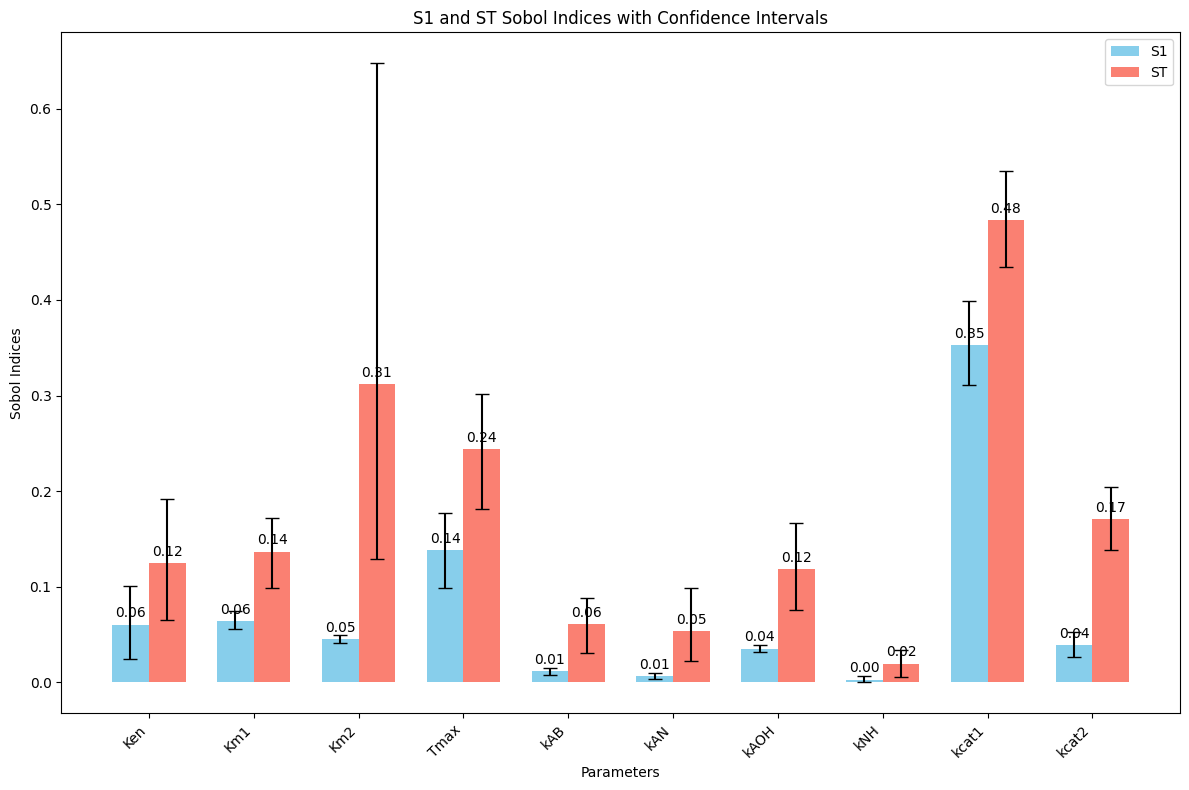

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Example placeholders, replace with actual data
parameters = df_bootstrap_results['parameter']
S1_values = df_bootstrap_results['S1_mean']
ST_values = df_bootstrap_results['ST_mean']
S1_CI_lower = df_bootstrap_results['S1_CI_lower']
S1_CI_upper = df_bootstrap_results['S1_CI_upper']
ST_CI_lower = df_bootstrap_results['ST_CI_lower']
ST_CI_upper = df_bootstrap_results['ST_CI_upper']

# Set up the bar chart
x = np.arange(len(parameters))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot S1 and ST as grouped bar charts
bars1 = ax.bar(x - width/2, S1_values, width, label='S1', color='skyblue', yerr=[S1_values - S1_CI_lower, S1_CI_upper - S1_values], capsize=5)
bars2 = ax.bar(x + width/2, ST_values, width, label='ST', color='salmon', yerr=[ST_values - ST_CI_lower, ST_CI_upper - ST_values], capsize=5)

# Add some labels and titles
ax.set_xlabel('Parameters')
ax.set_ylabel('Sobol Indices')
ax.set_title('S1 and ST Sobol Indices with Confidence Intervals')
ax.set_xticks(x)
ax.set_xticklabels(parameters, rotation=45, ha="right")
ax.legend()

# Add value labels on top of bars (optional)
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):  # Avoid annotating NaN values
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout to prevent clipping
fig.tight_layout()


# Without mean

In [ ]:
from tqdm import tqdm
# Bootstrap from the unpacked Sobol indices DataFrame
n_bootstrap = 1000  # Number of bootstrap iterations
bootstrap_s1 = []
bootstrap_st = []

# Perform bootstrap sampling
for _ in tqdm(range(n_bootstrap)):
    # Resample rows with replacement
    resampled_df = df_all_si.sample(frac=1, replace=True)

    # Group by parameter and calculate the mean S1 and ST for each parameter
    grouped_means = resampled_df.groupby('parameter')[['S1', 'ST']].mean()

    # Append the results of this bootstrap iteration
    bootstrap_s1.append(grouped_means['S1'].values)
    bootstrap_st.append(grouped_means['ST'].values)

# Convert bootstrap results to NumPy arrays
bootstrap_s1 = np.array(bootstrap_s1)
bootstrap_st = np.array(bootstrap_st)

# Calculate confidence intervals (e.g., 95%)
s1_confidence_intervals = np.percentile(bootstrap_s1, [2.5, 97.5], axis=0)
st_confidence_intervals = np.percentile(bootstrap_st, [2.5, 97.5], axis=0)

# Create a DataFrame to store bootstrap results
df_bootstrap_results = pd.DataFrame({
    'parameter': parameters,
    'S1_mean': np.mean(bootstrap_s1, axis=0),
    'S1_CI_lower': s1_confidence_intervals[0, :],
    'S1_CI_upper': s1_confidence_intervals[1, :],
    'ST_mean': np.mean(bootstrap_st, axis=0),
    'ST_CI_lower': st_confidence_intervals[0, :],
    'ST_CI_upper': st_confidence_intervals[1, :]
})

# Save the bootstrap results to a CSV file
bootstrap_output_file = os.path.join(generalized_output_dir, 'bootstrap_sobol_indices.csv')
df_bootstrap_results.to_csv(bootstrap_output_file, index=False)

print(f"Bootstrap Sobol indices and confidence intervals saved to: {bootstrap_output_file}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:12<00:00, 77.91it/s]

Bootstrap Sobol indices and confidence intervals saved to: ./sobol_plots_luci\bootstrap_sobol_indices.csv


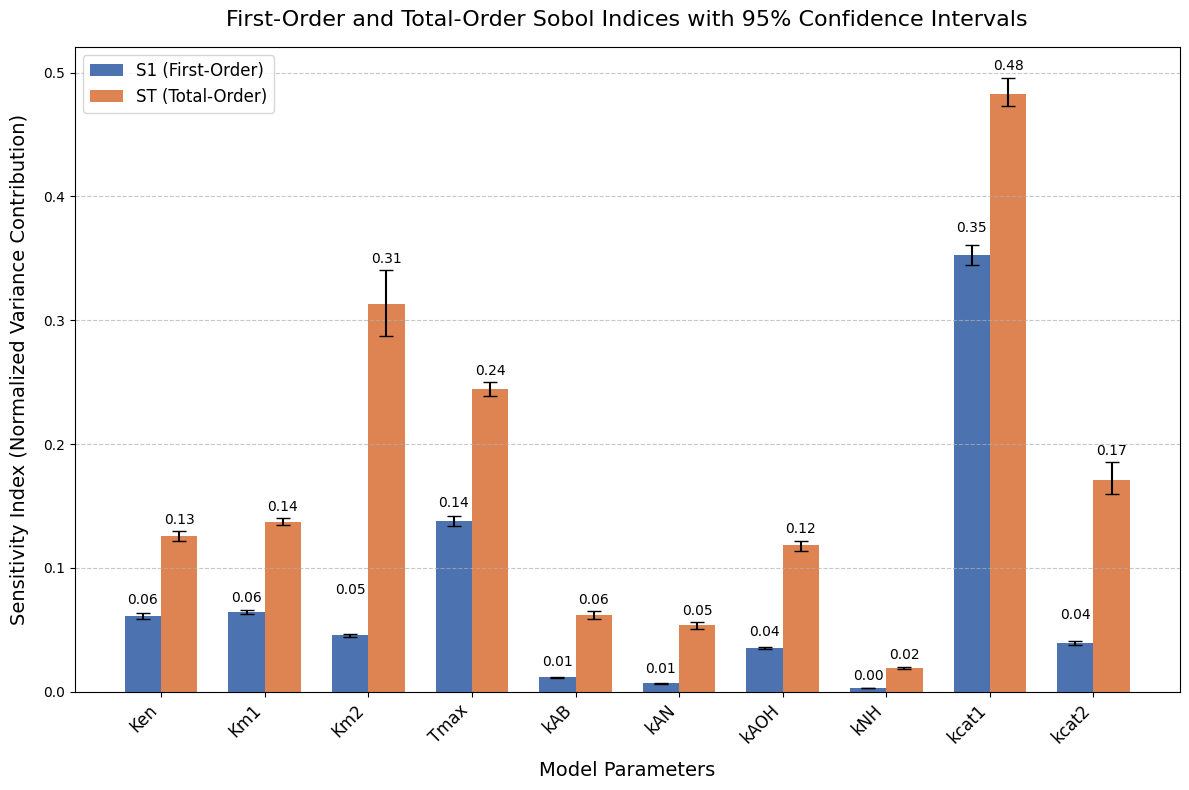

Academic-style plot saved to: ./sobol_plots_luci\sobol_indices_with_intervals_academic_fixed.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Replace these with your actual data
parameters = df_bootstrap_results['parameter']
S1_values = df_bootstrap_results['S1_mean']
ST_values = df_bootstrap_results['ST_mean']
S1_CI_lower = df_bootstrap_results['S1_CI_lower']
S1_CI_upper = df_bootstrap_results['S1_CI_upper']
ST_CI_lower = df_bootstrap_results['ST_CI_lower']
ST_CI_upper = df_bootstrap_results['ST_CI_upper']

# Validate data to ensure no missing or invalid values
if len(S1_values) != len(ST_values) or len(parameters) != len(S1_values):
    raise ValueError("Mismatch in the lengths of parameters, S1, or ST values.")

# Correct potential negative yerr values
S1_lower_err = np.maximum(S1_values - S1_CI_lower, 0)
S1_upper_err = np.maximum(S1_CI_upper - S1_values, 0)
ST_lower_err = np.maximum(ST_values - ST_CI_lower, 0)
ST_upper_err = np.maximum(ST_CI_upper - ST_values, 0)

# Ensure no invalid (e.g., NaN) values in error bars
if np.any(np.isnan(S1_lower_err)) or np.any(np.isnan(S1_upper_err)) or \
   np.any(np.isnan(ST_lower_err)) or np.any(np.isnan(ST_upper_err)):
    raise ValueError("NaN detected in confidence intervals. Check your data.")

# Set up the bar chart
x = np.arange(len(parameters))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot S1 and ST as grouped bar charts with error bars
bars1 = ax.bar(
    x - width / 2, S1_values, width, label='S1 (First-Order)',
    color='#4C72B0', yerr=[S1_lower_err, S1_upper_err], capsize=5
)
bars2 = ax.bar(
    x + width / 2, ST_values, width, label='ST (Total-Order)',
    color='#DD8452', yerr=[ST_lower_err, ST_upper_err], capsize=5
)

# Add labels and titles
ax.set_xlabel('Model Parameters', fontsize=14, labelpad=10)
ax.set_ylabel('Sensitivity Index (Normalized Variance Contribution)', fontsize=14, labelpad=10)
ax.set_title('First-Order and Total-Order Sobol Indices with 95% Confidence Intervals', fontsize=16, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(parameters, rotation=45, ha="right", fontsize=12)
ax.legend(fontsize=12, loc='upper left')

# Add horizontal grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
def add_value_labels(bars):
    count=0
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):  # Avoid annotating NaN values
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height+ST_upper_err[count]),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
        count+=1

add_value_labels(bars1)
add_value_labels(bars2)

# Adjust layout to prevent clipping
fig.tight_layout()

# Save the plot in a publication-friendly format
output_path = os.path.join(generalized_output_dir, 'sobol_indices_with_intervals_academic_fixed.png')
plt.savefig(output_path, dpi=300, format='png')

# Show the plot
plt.show()

print(f"Academic-style plot saved to: {output_path}")


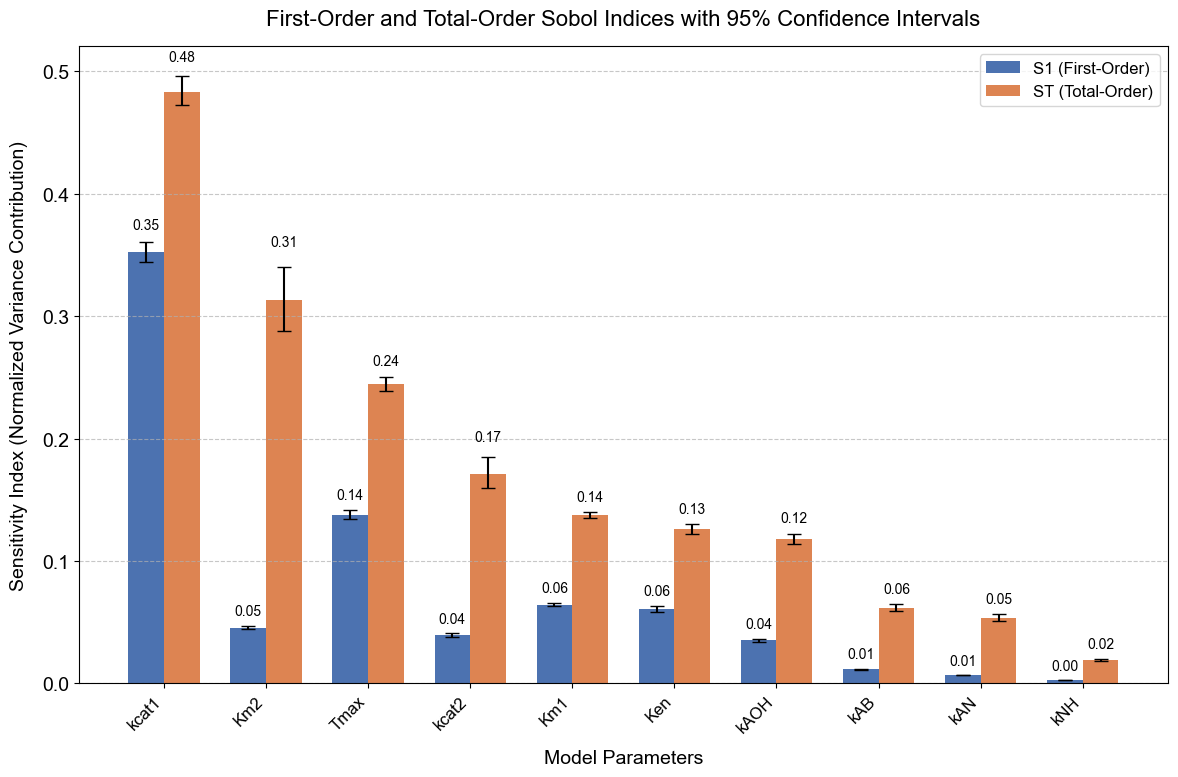

Academic-style plot saved to: ./sobol_plots_luci\sobol_indices_with_intervals_academic_sorted.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Replace these with your actual data
parameters = df_bootstrap_results['parameter']
S1_values = df_bootstrap_results['S1_mean']
ST_values = df_bootstrap_results['ST_mean']
S1_CI_lower = df_bootstrap_results['S1_CI_lower']
S1_CI_upper = df_bootstrap_results['S1_CI_upper']
ST_CI_lower = df_bootstrap_results['ST_CI_lower']
ST_CI_upper = df_bootstrap_results['ST_CI_upper']

# Validate data to ensure no missing or invalid values
if len(S1_values) != len(ST_values) or len(parameters) != len(S1_values):
    raise ValueError("Mismatch in the lengths of parameters, S1, or ST values.")

# Correct potential negative yerr values by calculating the positive errors
S1_lower_err = np.maximum(S1_values - S1_CI_lower, 0)
S1_upper_err = np.maximum(S1_CI_upper - S1_values, 0)
ST_lower_err = np.maximum(ST_values - ST_CI_lower, 0)
ST_upper_err = np.maximum(ST_CI_upper - ST_values, 0)

# Ensure no invalid (e.g., NaN) values in error bars
if np.any(np.isnan(S1_lower_err)) or np.any(np.isnan(S1_upper_err)) or \
   np.any(np.isnan(ST_lower_err)) or np.any(np.isnan(ST_upper_err)):
    raise ValueError("NaN detected in confidence intervals. Check your data.")

# Order parameters by their ST values
sorted_indices = np.argsort(ST_values)[::-1]  # Sort in descending order
parameters_sorted = np.array(parameters)[sorted_indices]
S1_values_sorted = np.array(S1_values)[sorted_indices]
ST_values_sorted = np.array(ST_values)[sorted_indices]
S1_lower_err_sorted = np.array(S1_lower_err)[sorted_indices]
S1_upper_err_sorted = np.array(S1_upper_err)[sorted_indices]
ST_lower_err_sorted = np.array(ST_lower_err)[sorted_indices]
ST_upper_err_sorted = np.array(ST_upper_err)[sorted_indices]

# Set up the bar chart
x = np.arange(len(parameters_sorted))  # the label locations
width = 0.35  # the width of the bars

# Set academic font (Arial)
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14})

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot S1 and ST as grouped bar charts with error bars
bars1 = ax.bar(
    x - width / 2, S1_values_sorted, width, label='S1 (First-Order)',
    color='#4C72B0', yerr=[S1_lower_err_sorted, S1_upper_err_sorted], capsize=5
)
bars2 = ax.bar(
    x + width / 2, ST_values_sorted, width, label='ST (Total-Order)',
    color='#DD8452', yerr=[ST_lower_err_sorted, ST_upper_err_sorted], capsize=5
)

# Add labels and titles
ax.set_xlabel('Model Parameters', fontsize=14, labelpad=10)
ax.set_ylabel('Sensitivity Index (Normalized Variance Contribution)', fontsize=14, labelpad=10)
ax.set_title('First-Order and Total-Order Sobol Indices with 95% Confidence Intervals', fontsize=16, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(parameters_sorted, rotation=45, ha="right", fontsize=12)
ax.legend(fontsize=12, loc='upper right')

# Add horizontal grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars (improved)
def add_value_labels(bars, yerr_lower, yerr_upper, ax):
    count = 0
    for bar, lower, upper in zip(bars, yerr_lower, yerr_upper):
        height = bar.get_height()
        
        # Set the label position slightly above the bar or error bar
        label_position = height + max(upper, lower) * 1  # 10% above the error bar
        
        if not np.isnan(height):  # Avoid annotating NaN values
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, label_position + (yerr_upper[count]/3)),
                        xytext=(0, 5),  # 5 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
        count += 1

# Call the function to add value labels on both bars
add_value_labels(bars1, S1_lower_err_sorted, S1_upper_err_sorted, ax)
add_value_labels(bars2, ST_lower_err_sorted, ST_upper_err_sorted, ax)

# Adjust layout to prevent clipping
fig.tight_layout()

# Save the plot in a publication-friendly format
output_path = os.path.join(generalized_output_dir, 'sobol_indices_with_intervals_academic_sorted.png')
plt.savefig(output_path, dpi=300, format='png')

# Show the plot
plt.show()

print(f"Academic-style plot saved to: {output_path}")


Bootstrap Sobol indices and confidence intervals saved to: ./sobol_plots_luci\bootstrap_sobol_indices.csv
